<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/deep_q_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Q-Network implementation
包括三个组成部分：

- approximate q-learning
- experience replay
- target networks 

In [0]:
import os
os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

### 目标: 训练一个玩atari的agent
游戏数据信息：
- atari 游戏画面图像默认大小是210x160x3

为了节省时间，可以对图像进行resize操作，变成64x64的黑白图像。并且去除顶部和底部无用的图像区域。

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from PIL import Image


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def observation(self, img, out_size=64):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        # crop image
        img=img[20:200,:,:]
        # resize
        img = Image.fromarray(img.astype(np.uint8))
        img = img.resize((out_size,out_size))
        # 灰度
        img = img.convert('L')

        #归一化：
        imgdata=np.matrix(img.getdata(),dtype='float')
        min_val = np.min(imgdata)
        max_val = np.max(imgdata)
        imgdata = (imgdata-min_val)/max_val
        imgdata.reshape((out_size, out_size))
        print("imgdata[0,:]".format(imgdata[0,:]))
        return imgdata

In [0]:
import gym
env = gym.make("BreakoutDeterministic-v0")

In [13]:
print(env.action_space)
print(env.observation_space)
s0 = env.reset()

Discrete(4)
Box(210, 160, 3)


In [0]:
from PIL import Image
import matplotlib.pyplot as plt


(210, 160, 3)
min_val=0.0	max_val=148.0


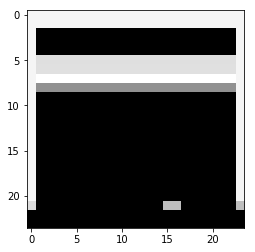

[[152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152. 152.
  152. 152. 152. 152. 152. 152. 152. 152. 152. 152.]]


In [103]:
data = s0
import numpy as np
print(data.shape)
data=data[20:210,:,:]
new_im = Image.fromarray(data.astype(np.uint8))
new_im = new_im.resize((24,24))
new_im = new_im.convert('L')

imgdata=np.matrix(new_im.getdata(),dtype='float')
min_val, max_val = np.min(imgdata), np.max(imgdata)
print("min_val={0}\tmax_val={1}".format(min_val, max_val))
#imgdata = (imgdata+200)

imgdata = imgdata.reshape((24,24))
imgdata = imgdata+10
plt.imshow(imgdata, cmap = plt.get_cmap('gray'))
plt.show()
print(imgdata[0])


In [82]:
min_val, max_val = np.min(imgdata), np.max(imgdata)
print(min_val)
print(max_val)
print(imgdata)
print((imgdata-min_val)/max_val)


0.0
148.0
[[142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142.
  142. 142. 142. 142. 142. 142. 142. 142. 142. 142.]
 [142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142. 142.
  142. 142. 142. 142. 142. 142. 142. 142. 142. 142.]
 [142.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0. 142.]
 [142.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0. 142.]
 [142.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0. 142.]
 [142. 129. 129. 129. 129. 129. 129. 129. 129. 129. 129. 129. 129. 129.
  129. 129. 129. 129. 129. 129. 129. 129. 129. 142.]
 [142. 130. 130. 130. 130. 130. 130. 130. 130. 130. 130. 130. 130. 130.
  130. 130. 130. 130. 130. 130. 130. 130. 130. 142.]
 [142. 148. 148. 148. 148. 148. 148. 148. 148. 148. 148. 148. 148. 148.
  148. 148. 148. 148. 148. 148. 148. 148. 1